In [1]:
from IPython.display import display, HTML

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st



In [2]:
def describe_dataframe(df_):
    n_rows, n_cols =  df_.shape
    num_desc= pd.concat([df_.select_dtypes('number').isnull().sum().to_frame(name = 'NA'), df_.describe(include= 'number').T], axis= 1)
    print(f'Number of rows: {n_rows}')
    print(f'Number of columns: {n_cols}')
    print('Numeric Columns summary')
    display(HTML(num_desc.to_html()))
    if df_.select_dtypes(exclude= np.number).shape[1] > 0:

        obj_desc = pd.concat([df_.select_dtypes(exclude= np.number).isnull().sum().to_frame(name = 'NA'), df_.describe(exclude= [np.number]).T], axis= 1)
    
        print('String Columns summary')
        display(HTML(obj_desc.to_html()))


In [2]:
data_dir = 'data/'

df = pd.read_parquet(data_dir + 'application_train.parquet')
ccb = pd.read_parquet(data_dir +'credit_card_balance.parquet')
ip = pd.read_parquet(data_dir + 'installments_payments.parquet')

### Application train Dataset

In [4]:
describe_dataframe(df)

Number of rows: 307511
Number of columns: 122
Numeric Columns summary


,NA,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,0,307511.0,278180.518577,102790.175348,1.000020e+05,189145.500000,278202.000000,367142.500000,4.562550e+05
TARGET,0,307511.0,0.080729,0.272419,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,0,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,0,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,0,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,12,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,278,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,0,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,0,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,0,307511.0,63815.045904,141275.766519,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05


String Columns summary


,NA,count,unique,top,freq
NAME_CONTRACT_TYPE,0,307511,2,Cash loans,278232
CODE_GENDER,0,307511,3,F,202448
FLAG_OWN_CAR,0,307511,2,N,202924
FLAG_OWN_REALTY,0,307511,2,Y,213312
NAME_TYPE_SUITE,1292,306219,7,Unaccompanied,248526
NAME_INCOME_TYPE,0,307511,8,Working,158774
NAME_EDUCATION_TYPE,0,307511,5,Secondary / secondary special,218391
NAME_FAMILY_STATUS,0,307511,6,Married,196432
NAME_HOUSING_TYPE,0,307511,6,House / apartment,272868
OCCUPATION_TYPE,96391,211120,18,Laborers,55186


#### Target

In [5]:
target_col = 'TARGET'

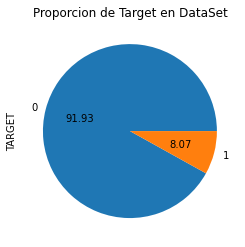

In [6]:
def autopct(pct): 
    return ('%.2f' % pct) if pct > 1 else ''

fig = plt.figure()
fig.patch.set_facecolor('white')

df[target_col].value_counts().plot(kind='pie',autopct=autopct)
plt.title("Proporcion de Target en DataSet")
plt.show()

Text(0.5, 1.0, 'Top 20 Features Correlating with Target')

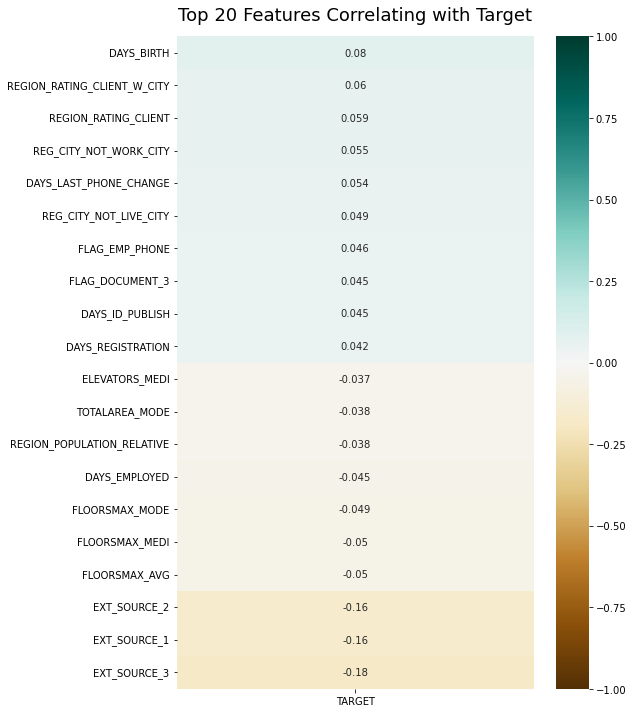

In [7]:
top_n_feature = 20

df_corr = df.sample(frac=0.25).corr()
top_features = [ c for c in df_corr[target_col].abs().nlargest(top_n_feature + 1 ).index.to_list() if c != target_col]

fig = plt.figure(figsize=(8, 12))
fig.patch.set_facecolor('white')
heatmap = sns.heatmap(df_corr.loc[top_features, [target_col]].sort_values(by=target_col, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title(f'Top {top_n_feature} Features Correlating with Target', fontdict={'fontsize':18}, pad=16)

#### Features Numericas

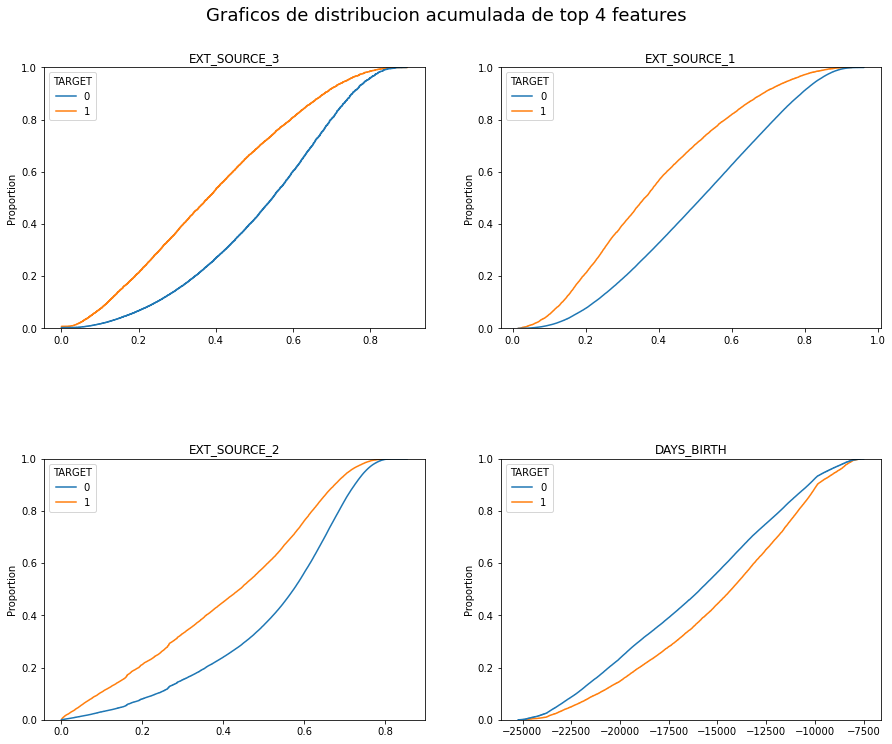

In [8]:
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Graficos de distribucion acumulada de top 4 features ", fontsize=18, y=0.95)


for f, ax in zip(top_features[:4], axs.ravel()):
    
    sns.ecdfplot(df, x=f, hue=target_col, log_scale = False, ax=ax )


    ax.set_title(f.upper())
    ax.set_xlabel("")

plt.show()

In [9]:
analysis_feature = top_features[0]
print(f'Test Estadístico T-Student de Diferencia de medias para {analysis_feature} \n')
p_threshold = 0.05
sample_0 = df.loc[df[target_col] == 0, analysis_feature]
sample_1 = df.loc[df[target_col] == 0, analysis_feature]
t, p, = st.ttest_ind(sample_0, sample_1)
if p < p_threshold:
    print ('Se observa envidencia que permite rechazar la hipotesis nula. Por lo que podemos suponer que existe una diferencia significativa entre las medias de ambos grupos.')
else:
    print ('No se observa envidencia que permite rechazar la hipotesis nula. Por lo tanto NO podemos afirmar que existe una diferencia significativa entre las medias de ambos grupos.')

Test Estadístico T-Student de Diferencia de medias para EXT_SOURCE_3 

No se observa envidencia que permite rechazar la hipotesis nula. Por lo tanto NO podemos afirmar que existe una diferencia significativa entre las medias de ambos grupos.


#### Features Dummy

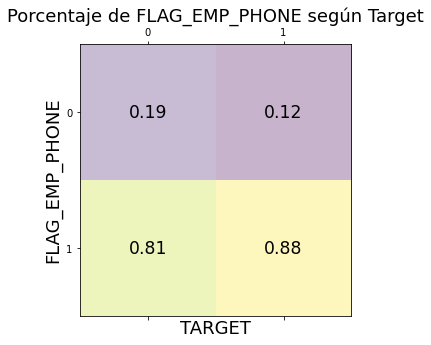

In [10]:
dummy_feature = 'FLAG_EMP_PHONE'

cros_tab = pd.crosstab(df[dummy_feature],df[target_col],  normalize = 'columns')

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cros_tab,  alpha=0.3)
for i in range(cros_tab.shape[0]):
    for j in range(cros_tab.shape[1]):
        ax.text(x=j, y=i,s= "%0.2f" % cros_tab.iloc[i, j], va='center', ha='center', size = 'xx-large')

plt.xlabel(target_col, fontsize=18)
plt.ylabel(dummy_feature, fontsize=18)
plt.title(f'Porcentaje de {dummy_feature} según Target', fontsize=18)
plt.show()

In [11]:
print('Test Estadístico Chi cuadrado de Independencia \n')
p_threshold = 0.05
chi2, p, dof, ex = st.contingency.chi2_contingency(cros_tab)
if p < p_threshold:
    print ('Se observa envidencia que permite rechazar la hipotesis nula de independecia por lo que podemos suponer una relacion entre ambas variables')
else:
    print ('No se observa envidencia que permite rechazar la hipotesis nula. Por lo tanto podemos asumir que ambas son  independientes.')

Test Estadístico Chi cuadrado de Independencia 

No se observa envidencia que permite rechazar la hipotesis nula. Por lo tanto podemos asumir que ambas son  independientes.


### Credit Card Balance Dataset

In [12]:
describe_dataframe(ccb)

Number of rows: 3840312
Number of columns: 23
Numeric Columns summary


,NA,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,0,3840312.0,1.904504e+06,536469.470563,1000018.000,1434385.00,1897122.0,2.369328e+06,2843496.000
SK_ID_CURR,0,3840312.0,2.783242e+05,102704.475133,100006.000,189517.00,278396.0,3.675800e+05,456250.000
MONTHS_BALANCE,0,3840312.0,-3.452192e+01,26.667751,-96.000,-55.00,-28.0,-1.100000e+01,-1.000
AMT_BALANCE,0,3840312.0,5.830016e+04,106307.031025,-420250.185,0.00,0.0,8.904669e+04,1505902.185
AMT_CREDIT_LIMIT_ACTUAL,0,3840312.0,1.538080e+05,165145.699523,0.000,45000.00,112500.0,1.800000e+05,1350000.000
AMT_DRAWINGS_ATM_CURRENT,749816,3090496.0,5.961325e+03,28225.688579,-6827.310,0.00,0.0,0.000000e+00,2115000.000
AMT_DRAWINGS_CURRENT,0,3840312.0,7.433388e+03,33846.077334,-6211.620,0.00,0.0,0.000000e+00,2287098.315
AMT_DRAWINGS_OTHER_CURRENT,749816,3090496.0,2.881696e+02,8201.989345,0.000,0.00,0.0,0.000000e+00,1529847.000
AMT_DRAWINGS_POS_CURRENT,749816,3090496.0,2.968805e+03,20796.887047,0.000,0.00,0.0,0.000000e+00,2239274.160
AMT_INST_MIN_REGULARITY,305236,3535076.0,3.540204e+03,5600.154122,0.000,0.00,0.0,6.633911e+03,202882.005


String Columns summary


,NA,count,unique,top,freq
NAME_CONTRACT_STATUS,0,3840312,7,Active,3698436


In [13]:
# Count of balances by ID
ccb.SK_ID_CURR.value_counts().describe()

count    103558.000000
mean         37.083683
std          33.483627
min           1.000000
25%          10.000000
50%          22.000000
75%          75.000000
max         192.000000
Name: SK_ID_CURR, dtype: float64

In [14]:
### Add Target column to ccb dataset
ccb = ccb.merge(df[[target_col, 'SK_ID_CURR']], on = 'SK_ID_CURR')

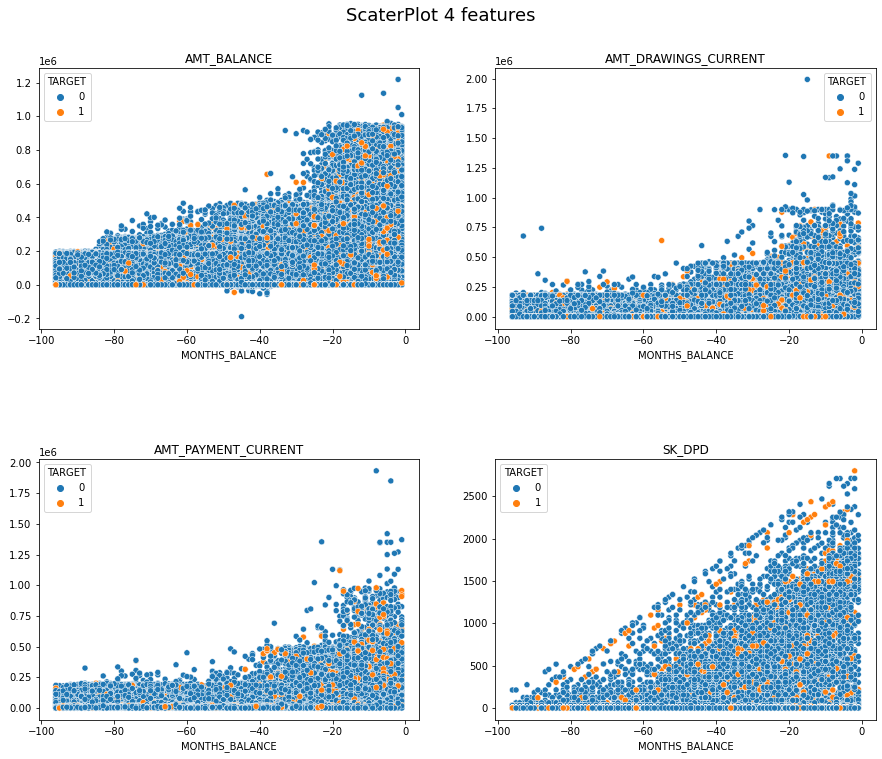

In [15]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("ScaterPlot 4 features ", fontsize=18, y=0.95)

features = ['AMT_BALANCE', 'AMT_DRAWINGS_CURRENT', 'AMT_PAYMENT_CURRENT', 'SK_DPD' ]
time_feature = 'MONTHS_BALANCE'
for f, ax in zip(features, axs.ravel()):
    
    sns.scatterplot(data = ccb.sample(frac=0.25), x=time_feature, y = f, hue=target_col,  ax=ax )


    ax.set_title(f.upper())
    ax.set_ylabel("")

plt.show()

### Instalment Payments Dataset

In [16]:
describe_dataframe(ip)

Number of rows: 13605401
Number of columns: 8
Numeric Columns summary


,NA,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,0,13605401.0,1.903365e+06,536202.905546,1000001.0,1434191.000,1896520.000,2369094.000,2843499.000
SK_ID_CURR,0,13605401.0,2.784449e+05,102718.310411,100001.0,189639.000,278685.000,367530.000,456255.000
NUM_INSTALMENT_VERSION,0,13605401.0,8.566373e-01,1.035216,0.0,0.000,1.000,1.000,178.000
NUM_INSTALMENT_NUMBER,0,13605401.0,1.887090e+01,26.664067,1.0,4.000,8.000,19.000,277.000
DAYS_INSTALMENT,0,13605401.0,-1.042270e+03,800.946284,-2922.0,-1654.000,-818.000,-361.000,-1.000
DAYS_ENTRY_PAYMENT,2905,13602496.0,-1.051114e+03,800.585883,-4921.0,-1662.000,-827.000,-370.000,-1.000
AMT_INSTALMENT,0,13605401.0,1.705091e+04,50570.254429,0.0,4226.085,8884.080,16710.210,3771487.845
AMT_PAYMENT,2905,13602496.0,1.723822e+04,54735.783981,0.0,3398.265,8125.515,16108.425,3771487.845


In [17]:
# Count of instalment payments by ID
ip.SK_ID_CURR.value_counts().describe()

count    339587.000000
mean         40.064552
std          41.053343
min           1.000000
25%          12.000000
50%          25.000000
75%          51.000000
max         372.000000
Name: SK_ID_CURR, dtype: float64

In [3]:
#Calculate difference between intallment and payment
ip['DAYS_DIFF'] =  ip['DAYS_INSTALMENT'] - ip['DAYS_ENTRY_PAYMENT']
ip['AMT_DIFF'] = ip['AMT_INSTALMENT'] - ip['AMT_PAYMENT']

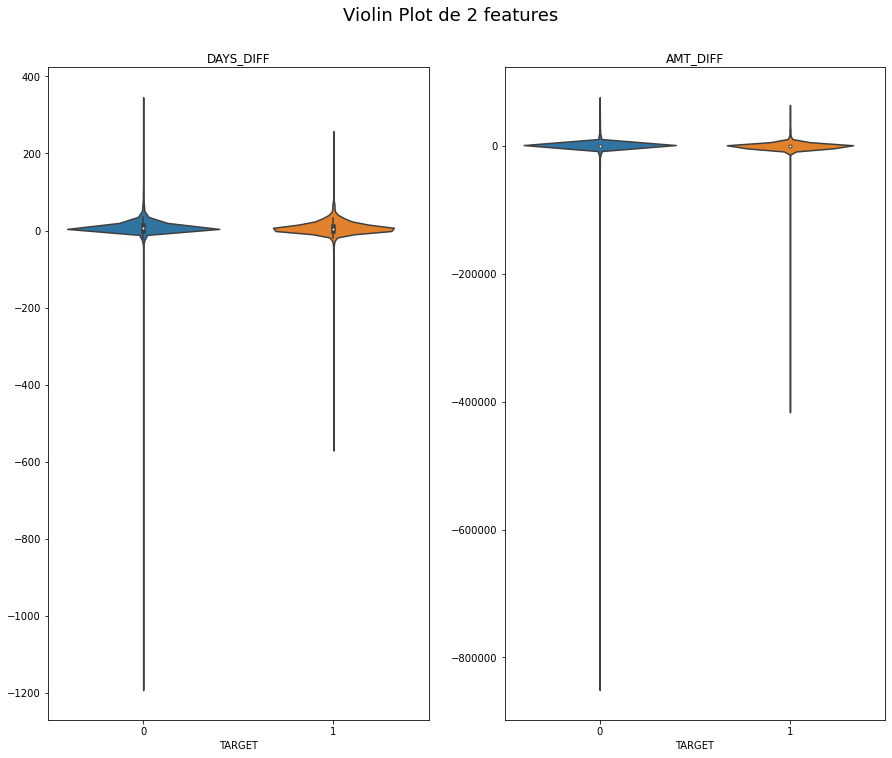

In [9]:
ip = ip.sample(frac= 0.25, random_state= 42)

### Add Target column to ip dataset
ip = ip[['SK_ID_CURR', 'DAYS_DIFF', 'AMT_DIFF']].merge(df[[target_col, 'SK_ID_CURR']], on = 'SK_ID_CURR')


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Violin Plot de 2 features ", fontsize=18, y=0.95)

features = ['DAYS_DIFF', 'AMT_DIFF' ]
time_feature = 'MONTHS_BALANCE'
for f, ax in zip(features, axs.ravel()):
    
    sns.violinplot(data = ip,  y = f, x=target_col,  ax=ax )


    ax.set_title(f.upper())
    ax.set_ylabel("")

plt.show()